# Spherical Distribution Models

Histology studies show that axons within one white matter bundle are not organized parallel to each other, but rather that their orientations are dispersed around the central bundle direction *(Leergaard et al. 2010)*.
The diffusion signal originating from tissue with dispersed axons can be modeled as the spherical convolution of a spherical distribution $G:\mathbb{S}^2\rightarrow[0,\infty]$ with a convolution kernel $K(\textbf{n})$ with $\textbf{n}\in\mathbb{S}^2$, where the kernel describes the diffusion signal of a single axon micro-environment.
Formally, this convolution can be written as
\begin{equation}
 E(\textbf{n})=\int_{\mathbb{S}^2}F(\textbf{n}-\textbf{g})K(\textbf{g})d\textbf{g}=(\operatorname{F}\,*_{\mathbb{S}^2}\,K)(\textbf{n})
\end{equation}
where $\textbf{g}\in\mathbb{S}^2$ is an integration variable, and we will use the second shorthand for spherical convolution in the rest of this article.
Given an axon bundle along $\textbf{n}_\parallel$, then the "sharpness" of $F$ along $\textbf{n}_\parallel$ describes the "spread", i.e. the dispersion of single axon micro-environments around $\textbf{n}_\parallel$. 
The chosen shape of $K(\textbf{n})$ varies between microstructure models and can be Sticks, Cylinders, Zeppelins or combinations thereof.
But once $K(\textbf{n})$ is known, $G$ can be recovered by spherical deconvolution of the signal with the kernel as $G(\textbf{n})=(E\,*^{-1}_{\mathbb{S}^2}\,K)(\textbf{n})$ with $*^{-1}_{\mathbb{S}^2}$ the deconvolution operator, or estimated using parametric distributions. In Dmipy, we do the latter with Watson or Bingham distributions.

## Watson and Bingham Distribution (SD1 and SD2)

To provide a more straightforward, but less general way to quantify axon dispersion, parameteric representations for $F$ such as the Bingham and Watson distribution have been proposed *(Kaden et al. 2007)*. 
We show schematic representations of both distributions the figure below.
The Bingham distribution $B(\textbf{n}|\boldsymbol{\mu},\kappa_1,\kappa_2)$ is an antipodally symmetric distribution, centered around direction $\boldsymbol{\mu}$, describing a possibly anisotropic density with concentration parameters $\kappa_1$ and $\kappa_2$ *(Bingham et al. 1974)*.
More formally, its probability density along normalized unit vector $\textbf{n}$ is given as
\begin{equation}
 \operatorname{B}(\textbf{n}|\boldsymbol{\mu},\kappa_1,\kappa_2)=\frac{\exp(\textbf{n}^T\textbf{Bn})}{4\pi\,_1F_1(1/2;3/2;\textbf{B})}\quad\textrm{with}\quad \textbf{B}=\textbf{R}^T\textbf{B}_{\textrm{diag}}\textbf{R}
\end{equation}

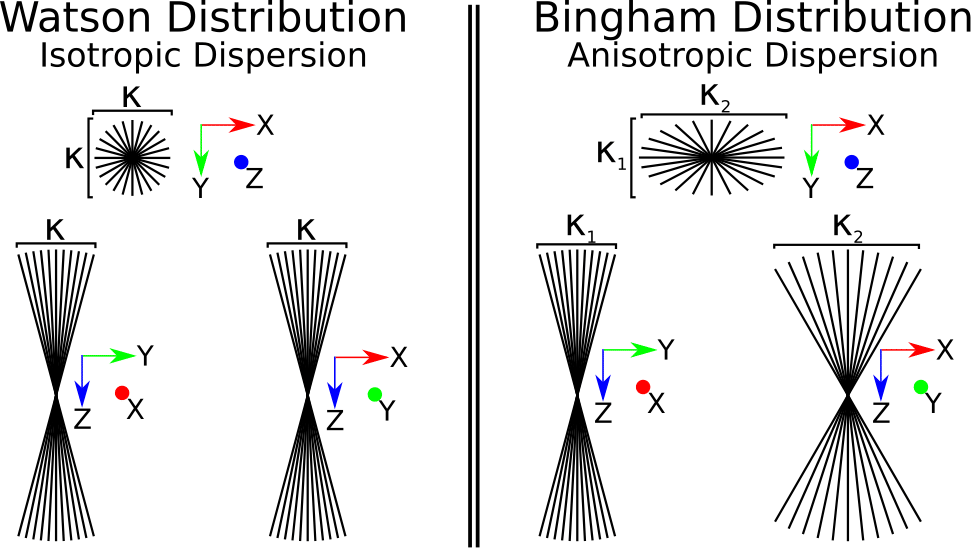

In [1]:
from IPython.display import Image
Image("dispersion_distributions.png", width=600)

with $_1F_1$ the confluent hypergeometric function, $\textbf{R}$ a rotation matrix that aligns the distribution with $\boldsymbol{\mu}$ and $\textbf{B}_{\textrm{diag}}=\textrm{Diag}(\kappa_1,\kappa_2,0)$. Note that concentration parameters $\kappa_1,\kappa_2$ are inversely related to dispersion. The Watson distribution $W(\textbf{n}|\boldsymbol{\mu},\kappa)$ is a special case of Bingham when $\kappa=\kappa_1=\kappa_2$, meaning $W(\textbf{n}|\boldsymbol{\mu},\kappa)=B(\textbf{n}|\boldsymbol{\mu},\kappa,\kappa)$.

\begin{equation}
 \operatorname{W}(\textbf{n}|\boldsymbol{\mu},\kappa)=\frac{\exp\left(\kappa(\boldsymbol{\mu}\cdot\textbf{n})^2\right)}{4\pi\,_1F_1(1/2;3/2;\kappa)}
\end{equation}

### Example and Intuition of Watson Distribution

A Watson distribution with concentration $\kappa$ is related to a spherical Gaussian distributions with standard deviation $\sigma_\phi$. To illustrate this, plot a spherical arc of a Watson distribution for different $\kappa$ and fit it to an explicit Gaussian distribution.

In [2]:
import numpy as np
def gauss_(x, amplitude, sigma):
    return amplitude * np.exp(-(x ** 2) / (2 * sigma ** 2))

In [3]:
from dipy.core.geometry import sphere2cart
mu = np.r_[0, 0]
theta_range = np.linspace(-np.pi / 2, np.pi / 2, 191)
degree_range = 180 * theta_range / np.pi
x_range, y_range, z_range = sphere2cart(np.ones(191), theta_range, np.zeros(191))
n = np.c_[x_range, y_range, z_range]

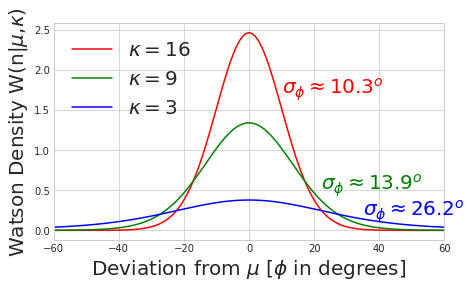

In [4]:
from dmipy.distributions.distributions import SD1Watson, kappa2odi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

odi = kappa2odi(np.r_[16, 9, 3])
watson = SD1Watson(mu=[0, 0])
y1 = watson(n, odi=odi[0])
_, sig1 = curve_fit(gauss_, degree_range, y1)[0]
y2 = watson(n, odi=odi[1])
_, sig2 = curve_fit(gauss_, degree_range, y2)[0]
y3 = watson(n, odi=odi[2])
_, sig3 = curve_fit(gauss_, degree_range, y3)[0]

plt.figure(figsize=[7, 4])
plt.plot(degree_range, y1, c='r', label=r'$\kappa=16$')
plt.plot(degree_range, y2, c='g', label=r'$\kappa=9$')
plt.plot(degree_range, y3, c='b', label=r'$\kappa=3$')
plt.xlabel('Deviation from $\mu$ [$\phi$ in degrees]', fontsize=20)
plt.ylabel('Watson Density W(n|$\mu$,$\kappa$)', fontsize=20)
plt.xlim(-60, 60)
plt.legend(fontsize=20, loc='upper left')
plt.text(10, 1.7, r'$\sigma_\phi\approx ' + str(round(sig1, 1)) + '^o$', fontsize=20, color='r')
plt.text(22, .5, r'$\sigma_\phi\approx ' + str(round(sig2, 1)) + '^o$', fontsize=20, color='g')
plt.text(35, .18, r'$\sigma_\phi\approx ' + str(round(sig3, 1)) + '^o$', fontsize=20, color='b');

We can see that larger $\kappa$ corresponds to a smaller $\sigma_\phi$. In literature, *(Ronen et al. 2013)* studied axon dispersion in the Corpus Callosum, and found that typical values in $\sigma_\phi$ are between 10 and 25 degrees. Plotting $\kappa$ and Orientation Dispersion Index (ODI) as a function of $\sigma_\phi$, we can get a feeling for what values to expect when fitting Watson distributions to real data.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:6592: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


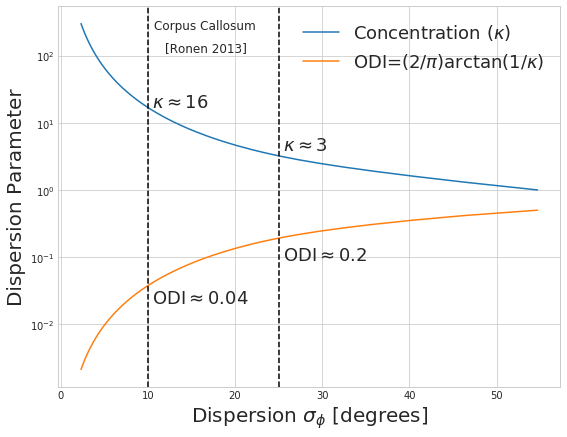

In [5]:
length = 1000
sigmas = np.zeros(length)
kappas = np.linspace(1., 300, length)
ODIs = kappa2odi(kappas)
for i, odi_ in enumerate(ODIs):
    y = watson(n, mu=mu, odi=odi_)
    _, sigmas[i] = curve_fit(gauss_, degree_range, y)[0]
plt.figure(figsize=[9, 7])
plt.semilogy(sigmas, kappas, label='Concentration ($\kappa$)')
plt.semilogy(sigmas, ODIs, label='ODI=(2/$\pi$)arctan(1/$\kappa$)')
plt.xlabel('Dispersion $\sigma_\phi$ [degrees]', fontsize=20)
plt.ylabel('Dispersion Parameter', fontsize=20)
plt.legend(fontsize=18)
plt.axvline(10, ymin=0, ymax=100, ls='--', color='k')
plt.axvline(25, ymin=0, ymax=100, ls='--', color='k')
plt.text(10.7, 250, 'Corpus Callosum', fontsize=12)
plt.text(12, 115, '[Ronen 2013]', fontsize=12)
plt.text(10.5, 17, r'$\kappa\approx16$', fontsize=18)
plt.text(25.5, 3.9, r'$\kappa\approx3$', fontsize=18)
plt.text(25.5, .09, r'ODI$\approx0.2$', fontsize=18)
plt.text(10.5, .021, r'ODI$\approx0.04$', fontsize=18);

As you can see, realistic values (in the Corpus Callosum) for $\kappa$ range between 3 and 16, which corresponds in ODI to values between 0.02 and 0.2.

### Example and Intuition of Bingham Distribution

A Bingham distribution is a generalization of the Watson by allowing a secondary dispersion parameter $\beta$, which enables dispersion anisotropy in secondary orientation $\psi$. To illustrate what this means, we reproduce Fig 3. from (*Tariq et al. 2016)*'s Bingham–NODDI model.

In [6]:
from dmipy.distributions.distributions import SD2Bingham
from scipy.interpolate import griddata

theta_range = np.linspace(0, np.pi / 2., 91)
phi_range = np.linspace(0, 2 * np.pi, 360)
theta_grid, phi_grid = np.meshgrid(theta_range, phi_range)

sampling_points = np.reshape(np.concatenate((np.array([theta_grid]), np.array([phi_grid]))),(2, -1)).T
theta_, phi_ = np.reshape(np.concatenate((np.array([theta_grid]), np.array([phi_grid]))),(2, -1))

x_, y_, z_ = sphere2cart(np.ones_like(phi_), theta_, phi_)
n = np.c_[x_, y_, z_]
bingam = SD2Bingham(mu=mu)

odi = kappa2odi(16)
beta_fraction = [0, 14 / 16., 1.]

data_k16_b0_psi0 = bingam(n, psi=0, odi=odi, beta_fraction=beta_fraction[0])
data_k16_b14_psi0 = bingam(n, psi=0, odi=odi, beta_fraction=beta_fraction[1])
data_k16_b16_psi0 = bingam(n, psi=0, odi=odi, beta_fraction=beta_fraction[2])
data_grid_k16_b0_psi0 = griddata(sampling_points, data_k16_b0_psi0, (theta_grid, phi_grid), method='nearest',fill_value=0)
data_grid_k16_b14_psi0 = griddata(sampling_points, data_k16_b14_psi0, (theta_grid, phi_grid), method='nearest',fill_value=0)
data_grid_k16_b16_psi0 = griddata(sampling_points, data_k16_b16_psi0, (theta_grid, phi_grid), method='nearest',fill_value=0)

data_k16_b0_psi1 = bingam(n, psi=np.pi/3, odi=odi, beta_fraction=beta_fraction[0])
data_k16_b14_psi1 = bingam(n, psi=np.pi/3, odi=odi, beta_fraction=beta_fraction[1])
data_k16_b16_psi1 = bingam(n, psi=np.pi/3, odi=odi, beta_fraction=beta_fraction[2])
data_grid_k16_b0_psi1 = griddata(sampling_points, data_k16_b0_psi1, (theta_grid, phi_grid), method='nearest',fill_value=0)
data_grid_k16_b14_psi1 = griddata(sampling_points, data_k16_b14_psi1, (theta_grid, phi_grid), method='nearest',fill_value=0)
data_grid_k16_b16_psi1 = griddata(sampling_points, data_k16_b16_psi1, (theta_grid, phi_grid), method='nearest',fill_value=0)

data_k16_b0_psi2 = bingam(n, psi=2*np.pi/3, odi=odi, beta_fraction=beta_fraction[0])
data_k16_b14_psi2 = bingam(n, psi=2*np.pi/3, odi=odi, beta_fraction=beta_fraction[1])
data_k16_b16_psi2 = bingam(n, psi=2*np.pi/3, odi=odi, beta_fraction=beta_fraction[2])
data_grid_k16_b0_psi2 = griddata(sampling_points, data_k16_b0_psi2, (theta_grid, phi_grid), method='nearest',fill_value=0)
data_grid_k16_b14_psi2 = griddata(sampling_points, data_k16_b14_psi2, (theta_grid, phi_grid), method='nearest',fill_value=0)
data_grid_k16_b16_psi2 = griddata(sampling_points, data_k16_b16_psi2, (theta_grid, phi_grid), method='nearest',fill_value=0)

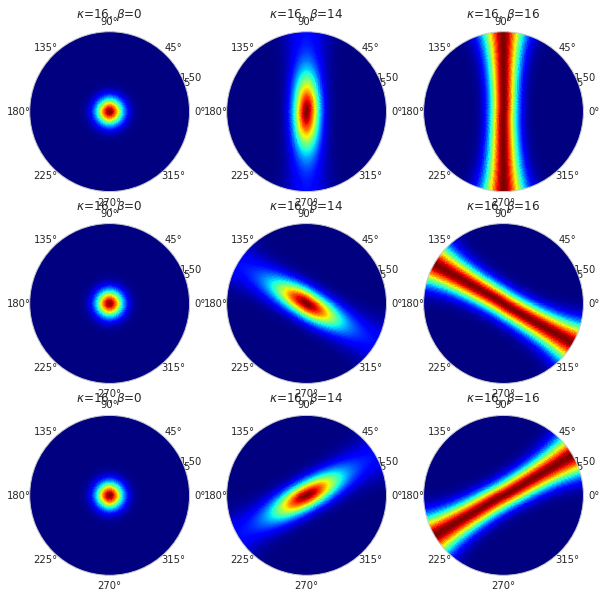

In [7]:
plt.figure(figsize=[10, 10])
ax = plt.subplot(331, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b0_psi0.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=0')
ax = plt.subplot(332, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b14_psi0.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=14')
ax = plt.subplot(333, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b16_psi0.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=16')

ax = plt.subplot(334, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b0_psi1.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=0')
ax = plt.subplot(335, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b14_psi1.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=14')
ax = plt.subplot(336, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b16_psi1.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=16')

ax = plt.subplot(337, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b0_psi2.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=0')
ax = plt.subplot(338, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b14_psi2.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=14')
ax = plt.subplot(339, projection="polar")
ax.pcolormesh(phi_range, theta_range, data_grid_k16_b16_psi2.T, cmap = 'jet')
ax.set_title(r'$\kappa$=16, $\beta$=16');

It can be seen that when $\kappa=\beta$, then the distribution corresponds to a narrow spherical band, but when $\kappa>\beta$ the Bingham distribution corresponds to an anisotropic Gaussian distribution on the sphere.

## References
- Leergaard, Trygve B., et al. "Quantitative histological validation of diffusion MRI fiber orientation distributions in the rat brain." PloS one 5.1 (2010): e8595.
- Kaden, Enrico, Thomas R. Knösche, and Alfred Anwander. "Parametric spherical deconvolution: Inferring anatomical connectivity using diffusion MR imaging." NeuroImage 37.2 (2007): 474-488.
- Bingham, Christopher. "An antipodally symmetric distribution on the sphere." The Annals of Statistics (1974): 1201-1225.
- Ronen, Itamar, et al. "Microstructural organization of axons in the human corpus callosum quantified by diffusion-weighted magnetic resonance spectroscopy of N-acetylaspartate and post-mortem histology." Brain Structure and Function 219.5 (2014): 1773-1785.
- Tariq, Maira, et al. "Bingham–noddi: Mapping anisotropic orientation dispersion of neurites using diffusion mri." NeuroImage 133 (2016): 207-223.